In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.constraints import *
from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.table.grammar_baseline import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
Meshcat url:  http://127.0.0.1:7003/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Set up grammar and constraint set.
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = TableBaseline,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
    sample_params_from_prior=True
)
constraints = [
    ObjectsOnTableConstraint(),
    ObjectSpacingConstraint()
]
print(grammar.all_types)

{<class 'spatial_scene_grammars_examples.table.grammar.Teapot'>, <class 'spatial_scene_grammars_examples.table.grammar_baseline.SteamerBottomBaseline'>, <class 'spatial_scene_grammars_examples.table.grammar_baseline.Teacups'>, <class 'spatial_scene_grammars_examples.table.grammar.Teacup'>, <class 'spatial_scene_grammars_examples.table.grammar_baseline.PersonalPlates'>, <class 'spatial_scene_grammars_examples.table.grammar.SteamerTop'>, <class 'spatial_scene_grammars_examples.table.grammar_baseline.TableBaseline'>, <class 'spatial_scene_grammars_examples.table.grammar.SharedTeapots'>, <class 'spatial_scene_grammars_examples.table.grammar_baseline.SharedSteamerTops'>, <class 'spatial_scene_grammars_examples.table.grammar.SharedDishes'>, <class 'spatial_scene_grammars_examples.table.grammar.PersonalPlate'>, <class 'spatial_scene_grammars_examples.table.grammar.ServingDish'>, <class 'spatial_scene_grammars_examples.table.grammar_baseline.SharedSteamerBottoms'>}


In [4]:
# Load the generated examples, and convert them to this grammar -- need
# to replace "SteamerBottom" with "SteamerBottomTerminal" and throw out
# trees.
from spatial_scene_grammars_examples.table.grammar import SteamerBottom, Table
observed_node_sets = []
with open("target_dataset_examples.pickle", "rb") as f:
    while 1:
        try:
            original_observed_node_set = pickle.load(f).get_observed_nodes()
            observed_node_set = []
            for node in original_observed_node_set:
                if isinstance(node, SteamerBottom):
                    new_node = SteamerBottomBaseline(tf=node.tf)
                elif isinstance(node, Table):
                    new_node = TableBaseline(tf=node.tf)
                else:
                    new_node = node
                observed_node_set.append(new_node)
            observed_node_sets.append(observed_node_set)
        except EOFError:
            break
print("Loaded %d environments" % len(observed_node_sets))

Loaded 100 environments


In [5]:
counts_by_type = {node_type.__name__: [] for node_type in grammar.all_types}
for nodes in observed_node_sets:
    dummy_tree = SceneTree.make_from_observed_nodes(nodes)
    for node_type in grammar.all_types:
        counts_by_type[node_type.__name__].append(
            len(dummy_tree.find_nodes_by_type(node_type))
        )
print("Max counts by type:", {key: max(value) for key, value in counts_by_type.items()})

Max counts by type: {'Teapot': 2, 'SteamerBottomBaseline': 6, 'Teacups': 0, 'Teacup': 4, 'PersonalPlates': 0, 'SteamerTop': 4, 'TableBaseline': 1, 'SharedTeapots': 0, 'SharedSteamerTops': 0, 'SharedDishes': 0, 'PersonalPlate': 4, 'ServingDish': 2, 'SharedSteamerBottoms': 0}


In [6]:
ex_k = 5
draw_scene_tree_contents_meshcat(SceneTree.make_from_observed_nodes(observed_node_sets[ex_k]),
                                 zmq_url=vis.window.zmq_url,  prefix="test_scene/contents")

[2022-01-24 22:35:23.844] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


In [7]:
# Do EM fitting process
em = EMWrapper(grammar, observed_node_sets, parsing_strategy="ip_noproposals", do_nlp_refinement=False)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=1, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (Teapot): None
    (SteamerBottomBaseline): None
    (Teacups): ConstrainedParameter()
    (Teacup): None
    (PersonalPlates): ConstrainedParameter()
    (SteamerTop): None
    (TableBaseline): ConstrainedParameter()
    (SharedTeapots): ConstrainedParameter()
    (SharedSteamerTops): ConstrainedParameter()
    (SharedDishes): ConstrainedParameter()
    (PersonalPlate): None
    (ServingDish): None
    (SharedSteamerBottoms): ConstrainedParameter()
  )
  (rule_params_by_node_type): ModuleDict(
    (Teapot): ModuleList()
    (SteamerBottomBaseline): ModuleList()
    (Teacups): ModuleList(
      (0): ModuleList(
        (0): ModuleDict(
          (mean): ConstrainedParameter()
          (variance): ConstrainedParameter()
        )
        (1): ModuleDict(
          (M): ConstrainedParameter()
          (Z): ConstrainedParameter()
        )
      )
    )
    (Teacup): ModuleList()
    (PersonalPlates): ModuleList(
      (0): M

In [8]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar_baseline.torch")
with open("fit_em_baseline.pickle", "wb") as fp:
    pickle.dump(em, fp)

# Little bit of statistics

In [9]:
fit_grammar = SpatialSceneGrammar(
    root_node_type = TableBaseline,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
fit_grammar.load_state_dict(torch.load("fit_grammar_baseline.torch"))

<All keys matched successfully>

In [10]:
# Get final parsed trees
post_fit_trees = []
for observed_nodes in tqdm(observed_node_sets):
    trees = infer_mle_tree_with_mip_from_proposals(
        fit_grammar, observed_nodes, {}, verbose=0, N_solutions=10, max_recursion_depth=10
    )
    post_fit_trees.append(trees)

  0%|          | 0/100 [00:00<?, ?it/s]

Before:  -10185.87507228049 After:  10517.036703034108


Text(0.5, 1.0, 'Mean and std of scene log p(o)')

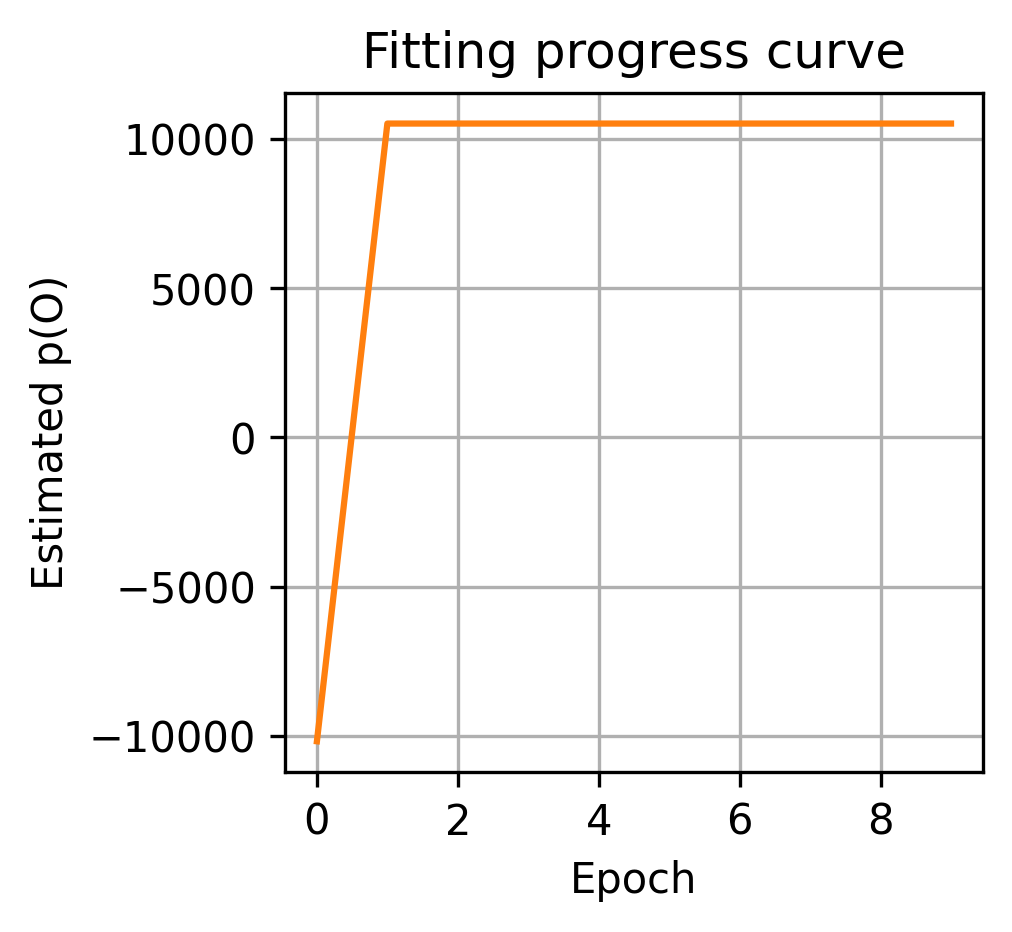

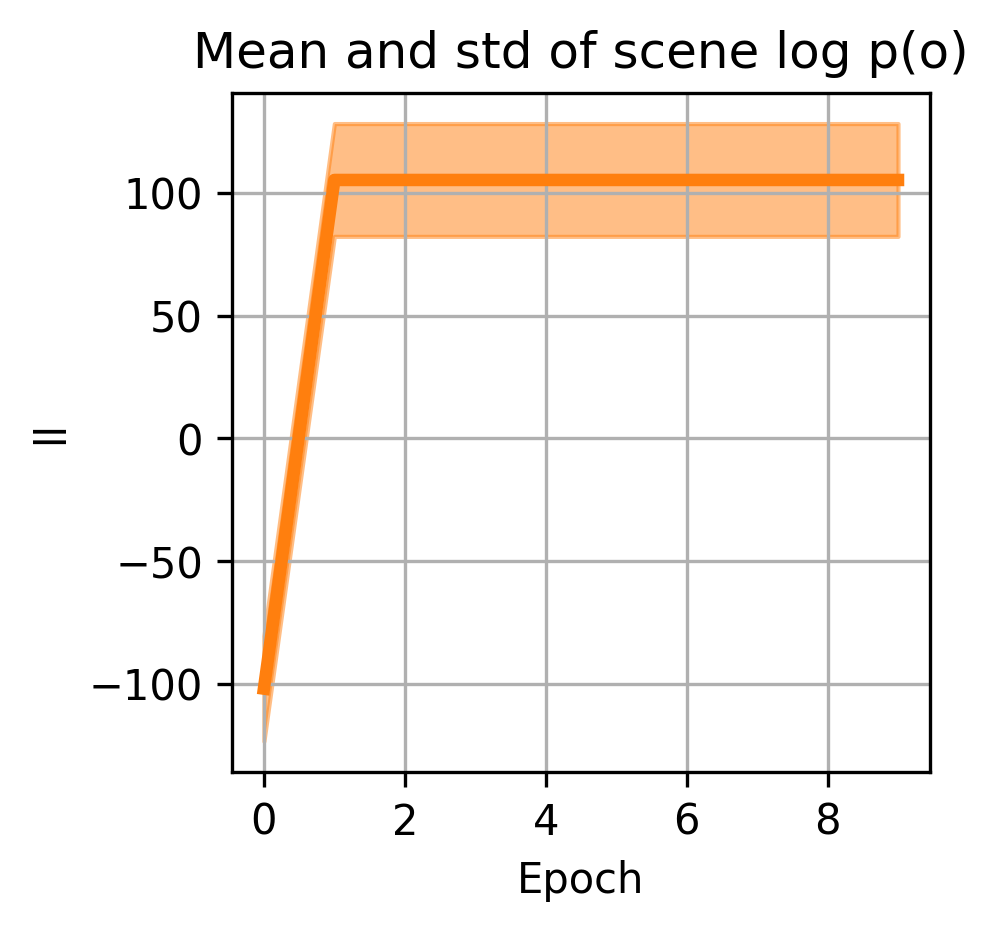

In [11]:
plt.figure(dpi=300).set_size_inches(3, 3)
totals = [np.sum(x) for x in em.log_evidence_iters]
plt.plot(totals, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("Estimated p(O)")
plt.title("Fitting progress curve")
print("Before: ", totals[0], "After: ", totals[-1])

# Slightly different: what's mean + avg p(o) for individual os look like?
plt.figure(dpi=300).set_size_inches(3, 3)
xs = range(len(em.log_evidence_iters))
means = np.array([np.mean(x) for x in em.log_evidence_iters])
stds = np.array([np.std(x) for x in em.log_evidence_iters])
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("ll")
plt.title("Mean and std of scene log p(o)")

In [25]:
# For each step over the fitting process, draw a population of samples from the
# candidate grammar, and collect the population of each terminal object type. Calculate
# MMDs against the corresponding populations of observed object types in the dataset.

# Precompute populations for dataset, and the dictionary we'll use to
# store the distance measurements.
observed_population_by_type = {}
for observed_nodes in observed_node_sets:
    for observed_node in observed_nodes:
        key = type(observed_node).__name__
        if key not in observed_population_by_type.keys():
            observed_population_by_type[key] = []
        observed_population_by_type[key].append(observed_node.tf)
for key, value in observed_population_by_type.items():
    observed_population_by_type[key] = torch.stack(value)

mmds_by_type = {key: [] for key in observed_population_by_type.keys()}

# For each EM iteration...
N_samples = 1000
mmd_alphas = [0.01, 0.1, 1.0, 10., 100.]
for k, grammar_state_dict in tqdm(enumerate(em.grammar_iters), total=len(em.grammar_iters)):
    grammar.load_state_dict(grammar_state_dict)
    # Build a population of observed nodes.
    sampled_population_by_type = {key: [] for key in observed_population_by_type.keys()}
    for k in range(N_samples):
        observed_nodes = grammar.sample_tree(detach=True).get_observed_nodes()
        for observed_node in observed_nodes:
            key = type(observed_node).__name__
            if key not in sampled_population_by_type:
                logging.warning("Sampled object not in observations: %s" % key)
                sampled_population_by_type[key] = []
            sampled_population_by_type[key].append(observed_node.tf)
    for key, value in sampled_population_by_type.items():
        sampled_population_by_type[key] = torch.stack(value)
    # Compute MMDs
    for key in observed_population_by_type.keys():
        observed_pop = observed_population_by_type[key]
        sampled_pop = sampled_population_by_type[key]
        if observed_pop.shape[0] > 0 and sampled_pop.shape[0] > 0:
            mmds_by_type[key].append(
                calculate_mmd(observed_pop, sampled_pop, alphas=mmd_alphas, use_se3_metric=True, beta=0.1)
            )
        else:
            logging.warning("%d observed, %d sampled, can't compare." % (observed_pop.shape[0], sampled_pop.shape[0]))
            mmds_by_type[key].append(np.inf)
print(mmds_by_type)

  0%|          | 0/11 [00:00<?, ?it/s]

{'TableBaseline': [tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15), tensor(9.7700e-15)], 'Teapot': [tensor(1.7043), tensor(-0.0035), tensor(-0.0008), tensor(-0.0029), tensor(-0.0038), tensor(-0.0028), tensor(-0.0045), tensor(-0.0033), tensor(-0.0042), tensor(-0.0041), tensor(-0.0029)], 'ServingDish': [tensor(1.3659), tensor(0.0187), tensor(0.0165), tensor(0.0171), tensor(0.0180), tensor(0.0149), tensor(0.0190), tensor(0.0171), tensor(0.0202), tensor(0.0212), tensor(0.0173)], 'SteamerBottomBaseline': [tensor(1.3924), tensor(0.0063), tensor(0.0062), tensor(0.0064), tensor(0.0057), tensor(0.0079), tensor(0.0069), tensor(0.0065), tensor(0.0070), tensor(0.0070), tensor(0.0068)], 'PersonalPlate': [tensor(1.0135), tensor(0.1716), tensor(0.1710), tensor(0.1672), tensor(0.1687), tensor(0.1699), tensor(0.1691), tensor(0.1722), tensor(0.1718), tens

In [26]:
with open("baseline_em_mmds_precomputed.pickle", "wb") as f:
    pickle.dump(mmds_by_type, f)

Initial: 1.632766 +/- 0.273919
Final: 0.003741 +/- 0.018560
TableBaseline: tensor(3.5527e-15)
Teapot: tensor(-0.0094)
ServingDish: tensor(0.0019)
SteamerBottomBaseline: tensor(-0.0047)
PersonalPlate: tensor(0.0400)
Teacup: tensor(0.0034)
SteamerTop: tensor(-0.0088)


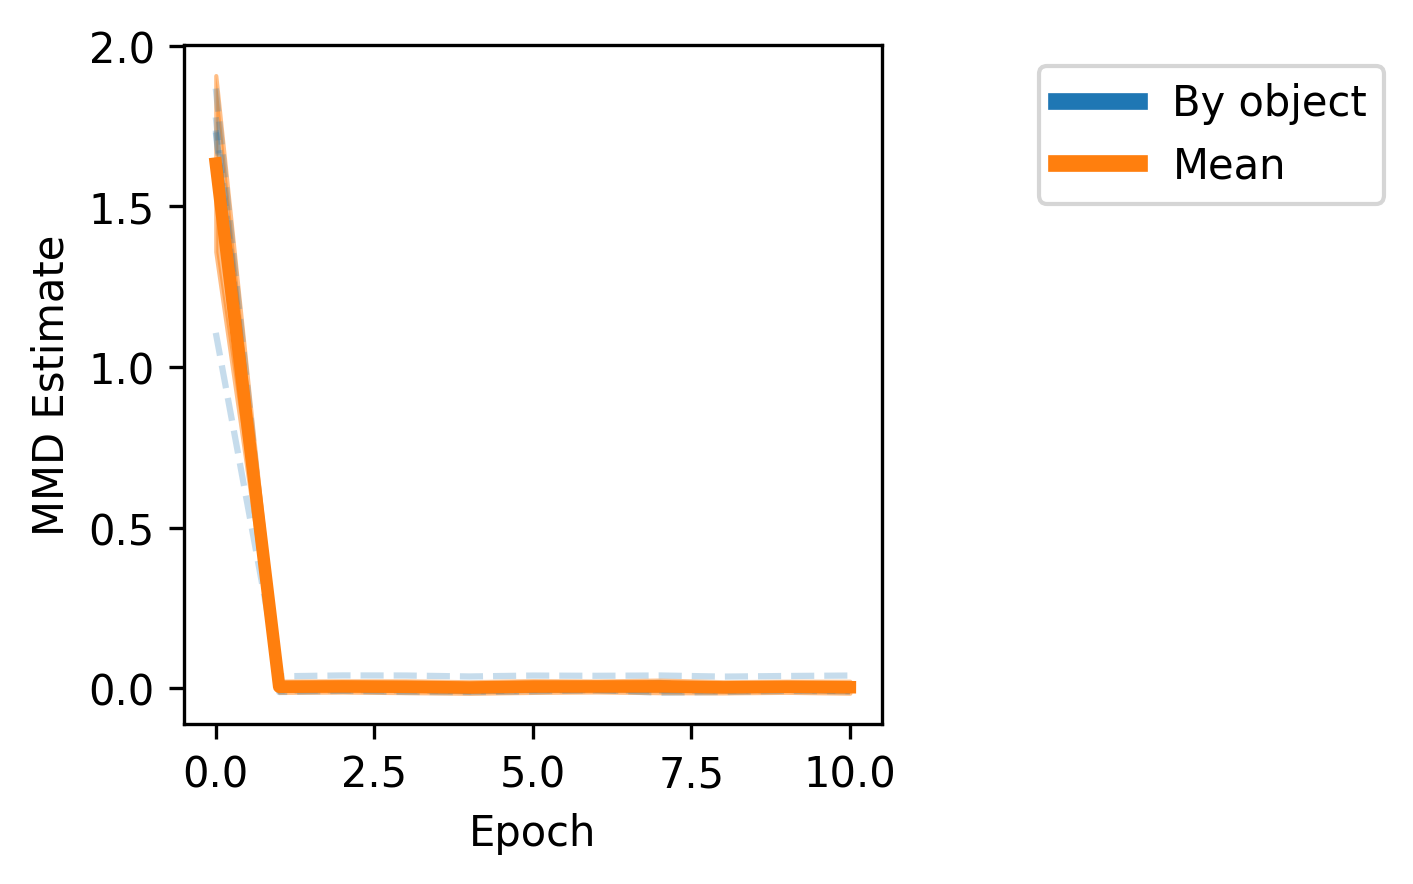

In [13]:
# Plot all of those over time.
plt.figure(dpi=300).set_size_inches(3, 3)

stacked_values = []
for key, value in mmds_by_type.items():
    if key == "TableBaseline":
        continue
    plt.plot(value, alpha=0.25, linestyle="--", c="tab:blue")
    stacked_values.append(torch.tensor(value))
stacked_values = torch.stack(stacked_values)
xs = range(stacked_values.shape[1])
means = torch.mean(stacked_values, dim=0)
stds = torch.std(stacked_values, dim=0)
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("MMD Estimate")
# Custom legend
from matplotlib.lines import Line2D
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_lines = [Line2D([0], [0], color="tab:blue", lw=4, label="By object"),
                Line2D([0], [0], color="tab:orange", lw=4, label="Mean")]
plt.gca().legend(handles=custom_lines, bbox_to_anchor=[1.75, 1])

initial_mmds = stacked_values[:, 0]
last_mmds = stacked_values[:, -1]
print("Initial: %f +/- %f" % (torch.mean(initial_mmds), torch.std(initial_mmds)))
print("Final: %f +/- %f" % (torch.mean(last_mmds), torch.std(last_mmds)))
for key, value in mmds_by_type.items():
    print("%s: %s" % (key, value[-1]))

Text(0.5, 1.0, 'Evolution of child offset in SharedSteamerBottoms\nWith 1/2 standard deviations')

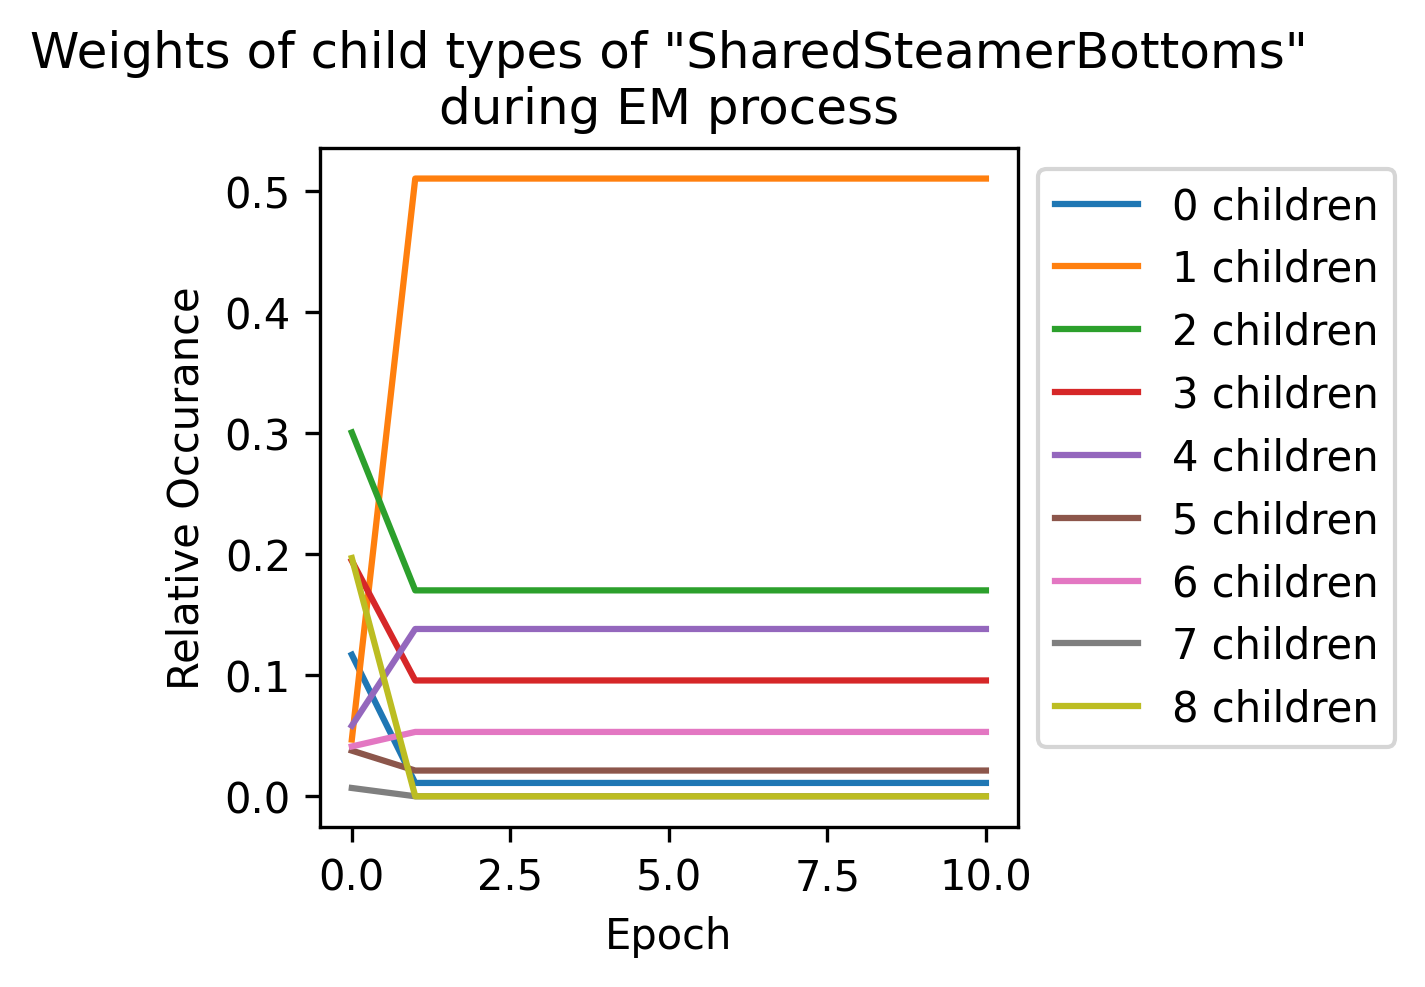

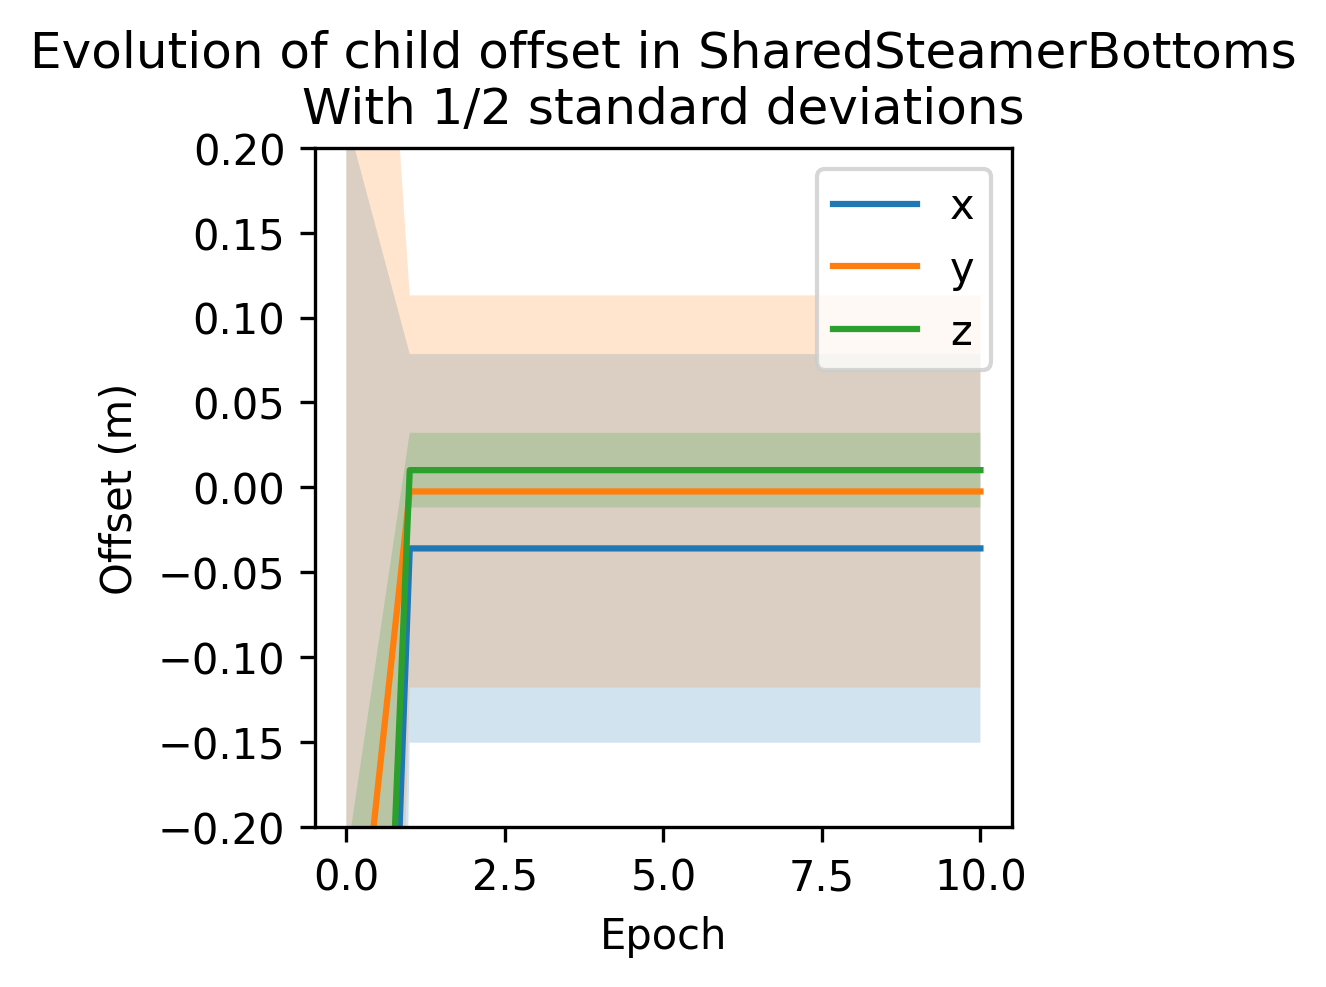

In [14]:
# Extract grammar history for SharedSteamerBottoms params + xyz offsets for first two (non-null) children

object_params_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    object_params_history.append(grammar.params_by_node_type["SharedSteamerBottoms"]().detach().numpy())
object_params_history = np.stack(object_params_history)
plt.figure(dpi=300).set_size_inches(3, 3)
for k in range(object_params_history.shape[1]):
    stuff = plt.plot(object_params_history[:, k], label="%d children" % k)
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Epoch")
plt.ylabel("Relative Occurance")
plt.title("Weights of child types of \"SharedSteamerBottoms\"\nduring EM process")

t_mean_history = []
t_var_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    t_mean_history.append(grammar.rule_params_by_node_type["SharedSteamerBottoms"][0][0]["mean"]().detach().numpy().copy())
    t_var_history.append(grammar.rule_params_by_node_type["SharedSteamerBottoms"][0][0]["variance"]().detach().numpy().copy())
t_mean_history = np.stack(t_mean_history)
t_var_history = np.stack(t_var_history)

plt.figure(dpi=300).set_size_inches(3, 3)
t_std_history = np.sqrt(t_var_history)*0.5
for k in range(3):
    xs = range(t_mean_history.shape[0])
    thing = plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
    plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)

plt.ylim(-0.2, 0.2)
plt.xlabel("Epoch")
plt.ylabel("Offset (m)")
plt.legend(bbox_to_anchor=[1, 1])
plt.title("Evolution of child offset in SharedSteamerBottoms\nWith 1/2 standard deviations")

Text(0.5, 1.0, 'Evolution of child offset in PersonalPlates\nWith 1/2 standard deviations')

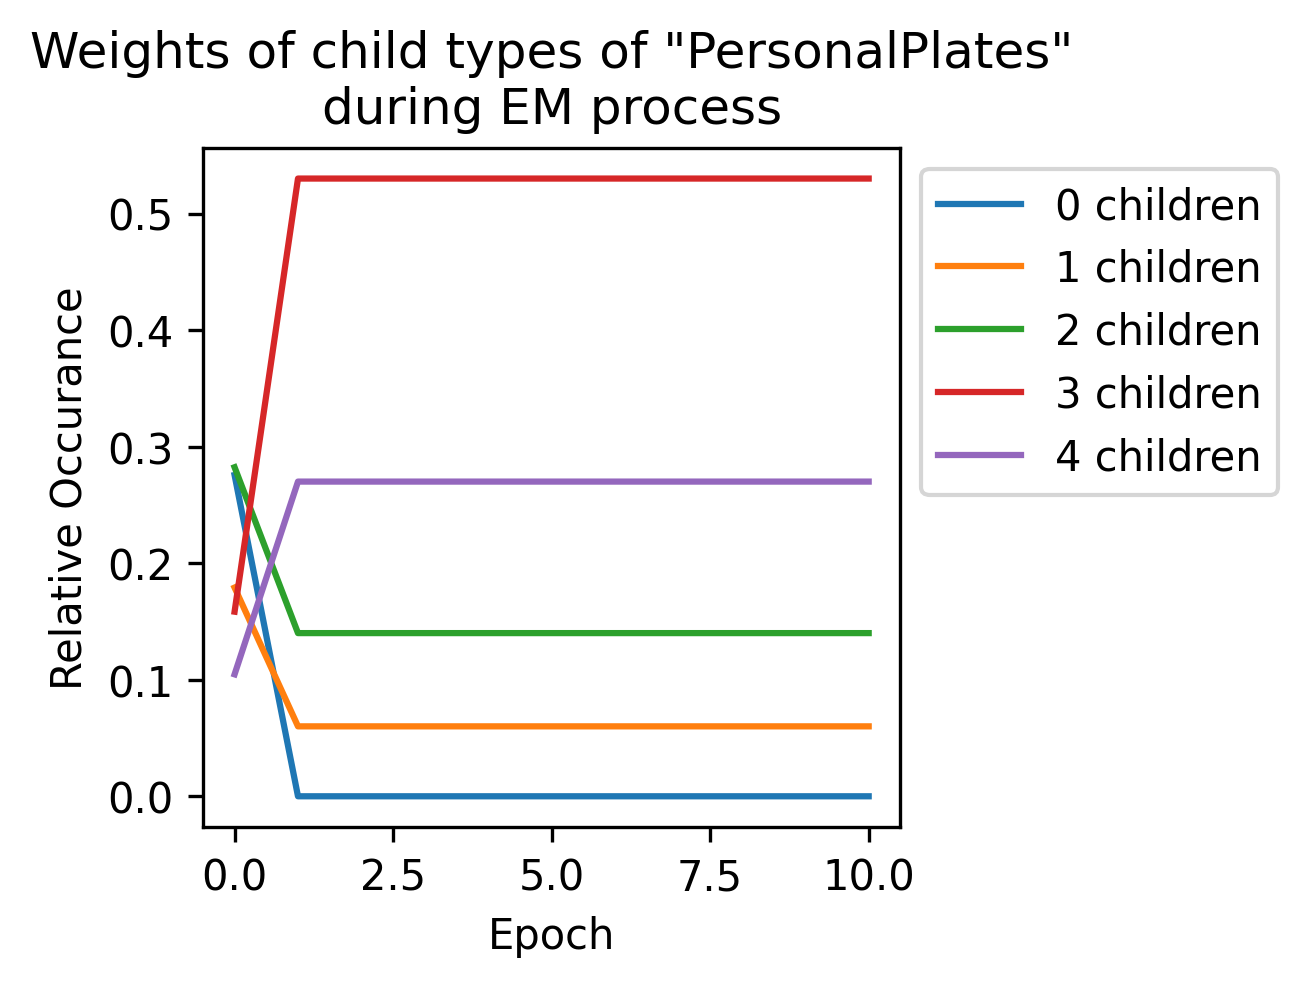

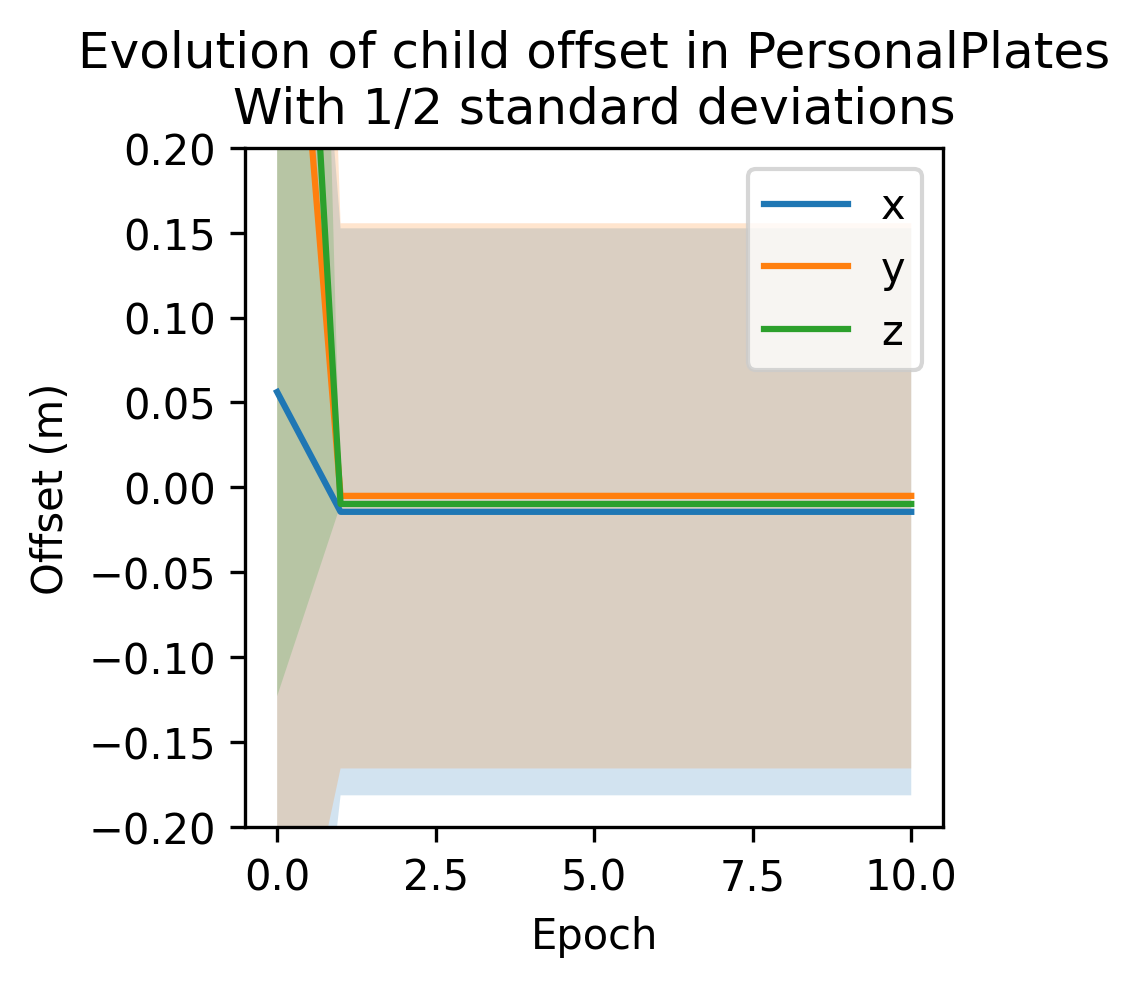

In [15]:
# Extract grammar history for SharedSteamerBottoms params + xyz offsets for first two (non-null) children

object_params_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    object_params_history.append(grammar.params_by_node_type["PersonalPlates"]().detach().numpy())
object_params_history = np.stack(object_params_history)
plt.figure(dpi=300).set_size_inches(3, 3)
for k in range(object_params_history.shape[1]):
    stuff = plt.plot(object_params_history[:, k], label="%d children" % k)
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Epoch")
plt.ylabel("Relative Occurance")
plt.title("Weights of child types of \"PersonalPlates\"\nduring EM process")

t_mean_history = []
t_var_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    t_mean_history.append(grammar.rule_params_by_node_type["PersonalPlates"][0][0]["mean"]().detach().numpy().copy())
    t_var_history.append(grammar.rule_params_by_node_type["PersonalPlates"][0][0]["variance"]().detach().numpy().copy())
t_mean_history = np.stack(t_mean_history)
t_var_history = np.stack(t_var_history)

plt.figure(dpi=300).set_size_inches(3, 3)
t_std_history = np.sqrt(t_var_history)*0.5
for k in range(3):
    xs = range(t_mean_history.shape[0])
    thing = plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
    plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)

plt.ylim(-0.2, 0.2)
plt.xlabel("Epoch")
plt.ylabel("Offset (m)")
plt.legend(bbox_to_anchor=[1, 1])
plt.title("Evolution of child offset in PersonalPlates\nWith 1/2 standard deviations")